In [44]:
import QuantLib as ql



TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

In [19]:
calc_date = ql.Date(14, 6, 2016)
ql.Settings.instance().evaluationDate = calc_date

# Market data for rates

In [37]:
dates = [ql.Date(14,6,2016), ql.Date(14,9,2016), 
         ql.Date(14,12,2016), ql.Date(14,6,2017),
         ql.Date(14,6,2019), ql.Date(14,6,2021),
         ql.Date(15,6,2026), ql.Date(16,6,2031),
         ql.Date(16,6,2036), ql.Date(14,6,2046)
         ]
yields = [0.000000, 0.006616, 0.007049, 0.007795,
          0.009599, 0.011203, 0.015068, 0.017583,
          0.018998, 0.020080]
day_count = ql.ActualActual(ql.ActualActual.ISDA)
calendar = ql.UnitedStates(ql.UnitedStates.NYSE )
interpolation = ql.Linear()
compounding = ql.Compounded
compounding_frequency = ql.Annual

term_structure = ql.ZeroCurve(dates, yields, day_count, calendar, 
                       interpolation, compounding, compounding_frequency)
ts_handle = ql.YieldTermStructureHandle(term_structure)


# Price capped floater with flat vol

In [38]:
start_date = ql.Date(14, 6, 2016)
end_date = ql.Date(14, 6 , 2026)
period = ql.Period(3, ql.Months)
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
buss_convention = ql.ModifiedFollowing
rule = ql.DateGeneration.Forward
end_of_month = False

schedule = ql.Schedule(start_date, end_date, period,
                       calendar, buss_convention, buss_convention, 
                       rule, end_of_month)

In [39]:
ibor_index = ql.USDLibor(ql.Period(3, ql.Months), ts_handle)
ibor_index.addFixing(ql.Date(10,6,2016), 0.0065560)

ibor_leg = ql.IborLeg([1000000], schedule, ibor_index)


In [40]:
strike = 0.02
cap = ql.Cap(ibor_leg, [strike])

vols = ql.QuoteHandle(ql.SimpleQuote(0.547295))
engine = ql.BlackCapFloorEngine(ts_handle, vols)

cap.setPricingEngine(engine)
print(cap.NPV())

54369.85806286925


# Vola surface

In [29]:
strikes = [0.01,0.015, 0.02]
expiries = [ql.Period(i, ql.Years) for i in range(1,11)] + [ql.Period(12, ql.Years)]
vols = ql.Matrix(len(expiries), len(strikes))
data = [[47.27, 55.47, 64.07, 70.14, 72.13, 69.41, 72.15, 67.28, 66.08, 68.64, 65.83],
   [46.65,54.15,61.47,65.53,66.28,62.83,64.42,60.05,58.71,60.35,55.91],
   [46.6,52.65,59.32,62.05,62.0,58.09,59.03,55.0,53.59,54.74,49.54]
   ]

for i in range(vols.rows()):
    for j in range(vols.columns()):
        vols[i][j] = data[j][i]/100.0

In [30]:
print(data)


[[47.27, 55.47, 64.07, 70.14, 72.13, 69.41, 72.15, 67.28, 66.08, 68.64, 65.83], [46.65, 54.15, 61.47, 65.53, 66.28, 62.83, 64.42, 60.05, 58.71, 60.35, 55.91], [46.6, 52.65, 59.32, 62.05, 62.0, 58.09, 59.03, 55.0, 53.59, 54.74, 49.54]]


In [32]:
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
bdc = ql.ModifiedFollowing
daycount = ql.Actual365Fixed()
settlement_days = 2
capfloor_vol = ql.CapFloorTermVolSurface(settlement_days, calendar, bdc, expiries, strikes, vols, daycount)

In [33]:
optionlet_surf = ql.OptionletStripper1(capfloor_vol, ibor_index)
ovs_handle = ql.OptionletVolatilityStructureHandle(
    ql.StrippedOptionletAdapter(optionlet_surf)
)


In [34]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

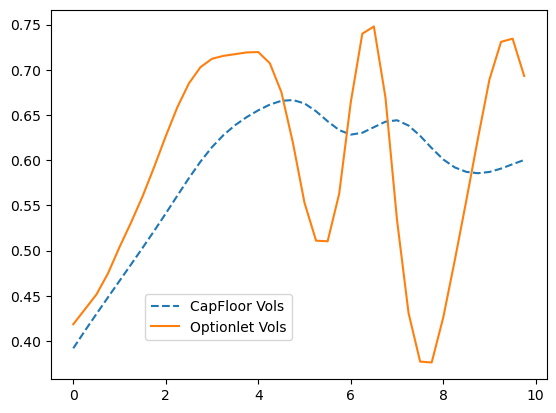

In [35]:
tenors = np.arange(0,10,0.25)
strike = 0.015
capfloor_vols = [capfloor_vol.volatility(t, strike) for t in tenors]
opionlet_vols = [ovs_handle.volatility(t, strike) for t in tenors]

plt.plot(tenors, capfloor_vols, "--", label="CapFloor Vols")
plt.plot(tenors, opionlet_vols,"-", label="Optionlet Vols")
plt.legend(bbox_to_anchor=(0.5, 0.25))


In [36]:
engine2 = ql.BlackCapFloorEngine(ts_handle, ovs_handle)
cap.setPricingEngine(engine2)
print(cap.NPV())

54384.928314950135
